# Example Analysis: Matrix Multiplication

## Problem Statement
### Background
We're going to look at matrix multiplication, a fundemental component of Linear Algebra and the backbone of many scientific programs. While on paper, it literally looks like $AB$, behind the scenes there's a lot more going on (and an entire field of theoretical and experimental research) to optimize this operation. 

In general, the multiplication of matrices $A$ of size $n \cdot m$ and $B$ of size $m \cdot p$ yields $C$ of size $n \cdot p$. This is further defined as $$\forall_{1 \le i \le n} \; \forall_{1 \le j \le p} \; c_{ij} = \sum_{k=1}^{m} a_{ik}b_{kj}$$

##### Cache Lines

Remember back to Systems or possibly CS2 when you learned how memory is organized on a computer as rows of bytes of memory, with different levels of cache corresponding to different physical areas in the processor with different speeds and sizes (smaller size -> faster access). One goal of optimizing matrix multiplication is to choose an appropriate access pattern of $A$, $B$, and $C$ that minimizes the number of cache misses, which is when we try to access an element that it outside of what we have cached and need to fetch it. Fetching from a cache miss takes far longer than doing the actual multiplication itself, so it becomes the bottleneck to avoid. 

## Hypothesis
#### Minimizing Cache Misses
We can think of a simple algorithm for a matrix multiplication, assuming $C$ is initialized to all zeros (default in Java, not default in C).

```julia
function matmul(A, B):
    n, m = size(A)
    _, p = size(B)

    C = zeros(n, p)
    
    for i in 1:n
        for j in 1:p
            for k in 1:m
                C[i,j] += A[i, k] * B[k, j]
            end
        end
    end
    C
end
```

We also note that the order in which we loop through $i$, $j$ and $k$ is irrelevant from the correctness perspective. But with some intuition it's clear that the way $i$, $j$ and $k$ vary with each other is highly relevant to the access patterns of $A$, $B$ and $C$. Since it is correct to reorder the loops, we should experiment to determine which access pattern will be best. Furthermore, it might be useful to know how our language orders Arrays. The options are row-major, which you are more familiar with since it is how all C-like languages structure Arrays, but another option is column-major where the matrix is ordered as below. Column-Major happens to be how Julia, the target language, structures its Arrays so we also need to note that our optimal loop order will be unlikely to generalize to row-major languages. 

<center>
    <figure>
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Row_and_column_major_order.svg/1200px-Row_and_column_major_order.svg.png" width=200>
        <figcaption>Source: Wikipedia Matrix Multipliction Algorithms</figcaption>
    </figure>
</center>

There is furthermore another divide and conquer method defined on the Wikipedia page for Matrix Multiplication Algorithms which we will also benchmark. We'll benchmark this method because it will also demonstrate some of the trade-offs between theoretical asymptotic behavior and real-world behavior that is influenced by recursion overhead. 


#### Language-Specific Notes
Because we are using Julia, there are a few things we need to look at ahead of time to design a good algorithm. 

1. `@propogate_inbounds`: Julia defines this macro to let the compiler know that bounds checking is not required for this method. This will speed up computations since every access of an Array does not requires a bounds check (saving $O(n^3)$ checks). We can do this because everything is determined by `n, m, p` which are by definition in bounds. 

2. `@view`: Julia, like most modern languages, allows for fancy indexing (slicing) of the array. However, Julia's default behavior is to return an independent array. So say `A[1, :]` returns the first row of `A`, however the 1D array it will return is independent of `A` itself. Under the hood, this means Julia is copying this row to a new location in memory. We don't need this for the divide and conquer algorithm because we don't modify `A` or `B`, so we can use the `@view` macro to avoid the memory copy overhead. 

3. `vcat(), hcat()`: Again, like most modern languages, Julia allows for efficient manipulation of Arrays. `vcat` is equivalent to vertically stacking its arguments on top of each other, and `hcat` is analagous for horizontal stacking. 

4. **Precompilation**: Julia is a bit of an oddball language because it is both interpreted and compiled. Python, while dynamic and easy to use/modify (and the reason you can have a python Jupyter Notebook) is slow due to being interpreted and running on top of a runtime environment. C and Fortran, on the other hand, are difficult to develop in due to needing to be statically typed and compiled. Julia mixes both worlds by allowing a piece of code to be interpreted during its first execution, and simultaneously during its execution it is compiled and cached for faster later use. While most of the time this is irrelevant, it's crucial to know this detail for benchmarking. Because the first executation of a function with a combination of typed arguments is interpreted and simultaneously compiled, it is *much much* slower than subsequent exeuctions. We will *always* have a maximum outlier corresponding to this execution and it may sometimes even significantly affect the mean of the execution times. Therefore, we will use the median as the statistic for execution speed. 

In [150]:
using Weave
using BenchmarkTools
using LsqFit
using Statistics
using LinearAlgebra
using Plots
using LaTeXStrings
using JSON

In [2]:
Base.@propagate_inbounds function matmul_ijk(A, B, C)
    n,  m = size(A)
    m′, p = size(B)
    n′, p′ = size(C)
    
    @assert m == m′
    @assert n == n′
    @assert p == p′
        
    for i in 1:n
        for j in 1:p
            for k in 1:m
                C[i,j] = C[i,j] + A[i, k] * B[k, j]
            end
        end
    end
    C
end

Base.@propagate_inbounds function matmul_jik(A, B, C)
    n,  m = size(A)
    m′, p = size(B)
    n′, p′ = size(C)
    
    @assert m == m′
    @assert n == n′
    @assert p == p′
        
    for j in 1:p
        for i in 1:n
            for k in 1:m
                C[i,j] += A[i, k] * B[k, j]
            end
            
        end
    end
    C
end

Base.@propagate_inbounds function matmul_kij(A, B, C)
    n,  m = size(A)
    m′, p = size(B)
    n′, p′ = size(C)
    
    @assert m == m′
    @assert n == n′
    @assert p == p′
        
    for k in 1:m
        for i in 1:n
            for j in 1:p
                C[i,j] += A[i, k] * B[k, j]
            end
        end
    end
    C
end

Base.@propagate_inbounds function matmul_kji(A, B, C)
    n,  m = size(A)
    m′, p = size(B)
    n′, p′ = size(C)
    
    @assert m == m′
    @assert n == n′
    @assert p == p′
        
    for k in 1:m
        for j in 1:p
            for i in 1:n
                C[i,j] += A[i, k] * B[k, j]
            end
        end
    end
    C
end

Base.@propagate_inbounds function recursive_matmul(A, B, C, basecase=10)
    n,  m = size(A)
    m′, p = size(B)
    n′, p′ = size(C)
    
    @assert m == m′
    @assert n == n′
    @assert p == p′
    
    max_dim = max(n, m, p)
    
    if max_dim < basecase
        return matmul_jik(A, B, C)
    elseif max_dim == n
        split1 = round(Integer, n/2)
        A1 = @view A[1:split1, :]
        A2 = @view A[split1 + 1:n, :]
        C1 = @view C[1:split1,   :]
        C2 = @view C[split1+1:p, :]
        C1 .= recursive_matmul(A1, B, C1, basecase)
        C2 .= recursive_matmul(A2, B, C2, basecase)
        return C
    elseif max_dim == p
        split1 = round(Integer, p/2)
        B1 = @view B[:, 1:split1]
        B2 = @view B[:, split1 + 1:p]
        C1 = @view C[:,   1:split1]
        C2 = @view C[:, split1+1:p]
        C2 .= recursive_matmul(A, B1, C2, basecase)
        C2 .= recursive_matmul(A, B2, C2, basecase)
        return C
    else
        split1 = round(Integer, m/2)
        A1 = @view A[:, 1:split1]
        A2 = @view A[:, split1 + 1:m]
        B1 = @view B[1:split1, :]
        B2 = @view B[split1 + 1:m, :]
        C.= recursive_matmul(A1, B1, basecase) + recursive_matmul(A2, B2, basecase)
        return C
    end
end

recursive_matmul (generic function with 2 methods)

# Benchmarking

Now that we've defined our code, it's time to benchmark it. Benchmarking is **one of the most difficult** tasks of any computational analysis. Benchmarking is highly error prone in terms of measuring the thing you actually want to measure, and requires *careful* planning to execute properly. Many, many computational papers have poor benchmarking and show conflicting or unreliable results because of it. 

Luckily, Julia takes care of much of the nitty-gritty in a package called `BenchmarkTools`, but we still need to be careful of a few things. The primary concern is to interpolate the variables using `$A` instead of `A` itself. Why we do that is a bit complicated, but you can read about it [here](https://github.com/JuliaCI/BenchmarkTools.jl/blob/master/doc/manual.md#interpolating-values-into-benchmark-expressions). In general, you want to be very careful of what you are timing. You may be timing setup/teardown (creating or deallocating) of arguments when you didn't want to, or even the timing function itself. Very often, people don't time what they mean to time, nor do they time it accurately.  

We then need to decide what inputs to test our implementations on. We want to see how our algorithms perform at the low end, around $n x n$ of around 10 to 100. We also want to see how it scales so we should test up to 2500. Any higher and I think the benchmarking will be too slow, but if you had the time it would be interesting to see it go higher. We will use square matrices to keep the inputs simple, but for the divide and conquer algorithm it would be important to see its performance on highly rectangular matrices as well. Non-square matrices will have different access patterns, but are also more degrees of freedom to test which is why we are skipping them. Similar to the above paragraph, when comparing algorithms against each other many people don't think carefully about what arguments they are picking. Especially when benchmarking for real-world applications, it's vital to pick arguments and conditions that reflect real-world scenarios. For your Dist Systems MPs, this is where almost all of the attention in testing needs to be: how do I accurately and properly simulate real-world conditions; can I do this exhaustively to catch every possible case that can be tested against? You'll see that this can become incredibly difficult, and often why testing occurs in production sometimes since production is the definition of real-world. 

We also want to find some reference implementations to test against. One might be Julia's default matrix multiplication `A * B`, and another might be a high performance package called BLAS, which Julia provides wrappers for. This will show us how much better Julia's hyperoptimized algorithms are compared to our relatively naive impelementations. Often, for extremely high performance, a compiler might even use different algorithms under the hood depending on what the size of the input is. We see this in the Divide and Conquer algorithm where under some theshhold we just use an iterative algorithm since it is faster. Benchmarking could be used to determine this threshhold. 

While BenchmarkTools takes care of the nitt-gritty for us, Go does not do it for you. You need to have a representative sample when benchmarking, which is certainly more than 1 data point. Benchmarktools often tests upwards of 10,000 iterations, but you can likely get away with 100-1000 as a proof of concept. In the case of matrix multiplication of square matrices, we would expect to see a normal distribution of execution times since there the algorithm performs the same number of operations each execution. For other algorithms, this isn't the case and you will need to make sure you have enough coverage of both the input arguments and executions with those algorithms to get a definitive distribution of the algorithm runtime (though assuming the algorithm is deterministic, run times with a fixed input should have a normal distribution). When interpreting, you need to understand that even if rare some combination of inputs gives a slow execution, the effect on the overall execution is likely very small -- but it is also important to note these cases since they are the important and interesting ones that show where the algorithm's design breaks down. 

As mentioned above, we will use the median runtime as our statistic. 

All benchmarks were run on a 2017 MacBook Pro with an Intel 3.5 GHz Dual-Core Intel Core i7 processor and 16 GB 2133 MHz LPDDR3 RAM using Julia 1.5.1 in this exact Jupyter Lab Notebook. For benchmarking cache behavior, you might also want to specify the cache configuration of your machine and processor combo. When benchmarking, it's important to specify as much exact information about your testing environment and methods in order to have reproducability or interpretability of your results. 

In [5]:
trials = [5, 10, 20, 30, 50, 75, 100, 150, 200, 250, 350, 500, 750, 1000];

In [6]:
ijk_trials = []

for m in trials
    A = rand(m, m)
    B = rand(m, m)
    C = zeros(m, m)
    
    t = @benchmark matmul_ijk($A, $B, $C) seconds=10 samples=100
    push!(ijk_trials, t)
end

Trial(164.497 ns)
Trial(1.267 μs)
Trial(13.650 μs)
Trial(46.027 μs)
Trial(206.372 μs)
Trial(781.004 μs)
Trial(1.944 ms)
Trial(6.912 ms)
Trial(17.042 ms)
Trial(33.804 ms)
Trial(94.554 ms)
Trial(284.060 ms)
Trial(981.704 ms)
Trial(2.425 s)


In [10]:
@. constrained_n3_regression(n, p) = p[1] + p[2] * n^3.
@. unconstrained_nx_regression(n, p) = p[1] + p[2] * n^p[3]

unconstrained_nx_regression (generic function with 1 method)

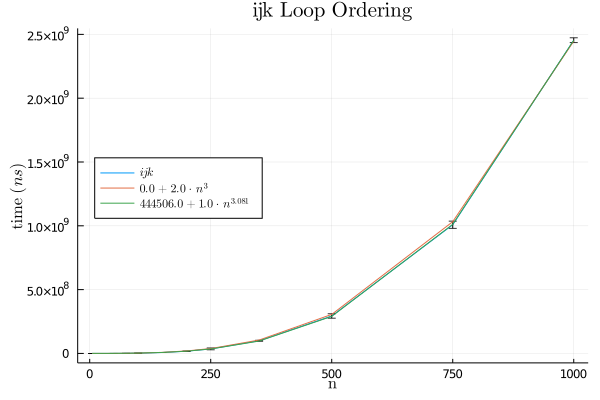

In [79]:
constrained_fit_ijk   = curve_fit(constrained_n3_regression , trials, [median(t.times) for t in ijk_trials], [0., 1.],
                                  lower=[0., -Inf], upper=[Inf, Inf])
unconstrained_fit_ijk = curve_fit(unconstrained_nx_regression, trials, [median(t.times) for t in ijk_trials], [0., 1., 3.],
                                  lower=[0., -Inf, 0.], upper=[Inf, Inf, Inf])

p1 = constrained_params_ijk   = coef(constrained_fit_ijk)
p2 = unconstrained_params_ijk = coef(unconstrained_fit_ijk)

plot( trials, [median(t.times) for t in ijk_trials], yerror=[std(t.times) for t in ijk_trials], label=L"ijk")
plot!(trials, constrained_n3_regression(trials, constrained_params_ijk)  , label=L"%$(round(p1[1])) + %$(round(p1[2])) \cdot n^3")
plot!(trials, unconstrained_nx_regression(trials, unconstrained_params_ijk), label=L"%$(round(p2[1])) + %$(round(p2[2])) \cdot n^{ %$(round(p2[3], digits=3))}")
plot!(legend=:left, title=L"\textrm{ijk Loop Ordering}", xlabel=L"\textrm{n}", ylabel=L"\textrm{time } (ns)")


Here we can start to see how things scale, and also how they fit our expectations for run time. 

This is for $ijk$ loop ordering, and we can see it performs strongly in $O(n^3)$. We perform a non-linear regression using two different models. A constrained model of the form $b + a * n^3$ and an unconstrained model of the form $b + a * n^c$. The first clearly forces the exponent to be constantly 3, the theoretical exponent of these algorithms. The second lets us just get a ballpark estimate in case it is running significantly better or worse than theoretical (in this case it won't due to good language design). 

We can see from the regressions that both visually fit the data extremely well, and that also the regressed exponent in the unconstrained model is 3.081 which is just overfitting noise in the model. We can strongly suggest out model runs in $O(n^3)$ time in real life as well. 

The included error bars give us an idea of uncertainty in our measurement, specifically as we get to high $n$ where the benchmark times out before reaching all 100 samples. But again visually, our errors are insignificant. We can also comment briefly on the performance, namely that we have sub 1 *ms* performance with $n$ lower than 250. Looking at the constrained regression, there is an intercept of 0 (expected) and a multiplicative constant of 2, meaning experimentally our algorithm is performing in the $ns$ and $\mu s$ range for small enough $n$. The 0 intercept means we have no significant constant penalty for running the algorithm (i.e., function call overhead). The multiplicative constant also appears rather okay, but this is what we want to improve by loop reordering so we need to compare it against the other 3 loop orders. The reason we have such good performance is because $A$, $B$, and $C$ are entirely pre-allocated with zeroed values in $C$. If the algorithm had to do this as well, we'd see significantly worse performance because we would also be measuring allocation and zeroing operations. 

In [80]:
jik_trials = []
kij_trials = []
kji_trials = []

for m in trials
    A = rand(m, m)
    B = rand(m, m)
    C = zeros(m, m)
    
    t = @benchmark matmul_jik($A, $B, $C) seconds=10 samples=100
    push!(jik_trials, t)
    
    t = @benchmark matmul_kij($A, $B, $C) seconds=10 samples=100
    push!(kij_trials, t)
    
    t = @benchmark matmul_kji($A, $B, $C) seconds=10 samples=100
    push!(kji_trials, t)
end

In [152]:
native_trials = []
blas_trials   = []

function native_wrapper(A, B, C)
    C .= A * B
end
    
for m in trials
    A = rand(m, m)
    B = rand(m, m)
    C = zeros(m, m)
    
    t = @benchmark native_wrapper($A, $B, $C) seconds=10 samples=100
    push!(native_trials, t) 
    
    t = @benchmark LinearAlgebra.BLAS.gemm!('N', 'N', 1., $A, $B, 1., $C) seconds=10 samples=100
    push!(blas_trials, t) 
end

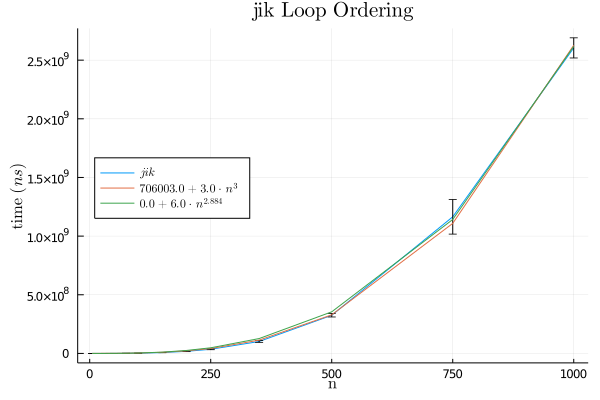

In [95]:
constrained_fit_jik   = curve_fit(constrained_n3_regression , trials, [median(t.times) for t in jik_trials], [0., 1.],
                                  lower=[0., -Inf], upper=[Inf, Inf])
unconstrained_fit_jik = curve_fit(unconstrained_nx_regression, trials, [median(t.times) for t in jik_trials], [0., 1., 3.],
                                  lower=[0., -Inf, 0.], upper=[Inf, Inf, Inf])

p1 = constrained_params_jik   = coef(constrained_fit_jik)
p2 = unconstrained_params_jik = coef(unconstrained_fit_jik)

plot( trials, [median(t.times) for t in jik_trials], yerror=[std(t.times) for t in jik_trials], label=L"jik")
plot!(trials, constrained_n3_regression(trials, constrained_params_jik)  , label=L"%$(round(p1[1])) + %$(round(p1[2])) \cdot n^3")
plot!(trials, unconstrained_nx_regression(trials, unconstrained_params_jik), label=L"%$(round(p2[1])) + %$(round(p2[2])) \cdot n^{ %$(round(p2[3], digits=3))}")
plot!(legend=:left, title=L"\textrm{jik Loop Ordering}", xlabel=L"\textrm{n}", ylabel=L"\textrm{time } (ns)")


Unlike above, here we see an unexpected intercept and the multiplicative constant has grown from 2 to 3. This is indicative of cache misses because their performance hit won't fit our model of $b + a * n^3$. If we were to analyze just this plot alone, we may conclude that because the constrained fit is still good, our algorithm has a relatively high constant function call overhead with a multaplicative constant of 3, but we would still say it is in $O(n^3)$.

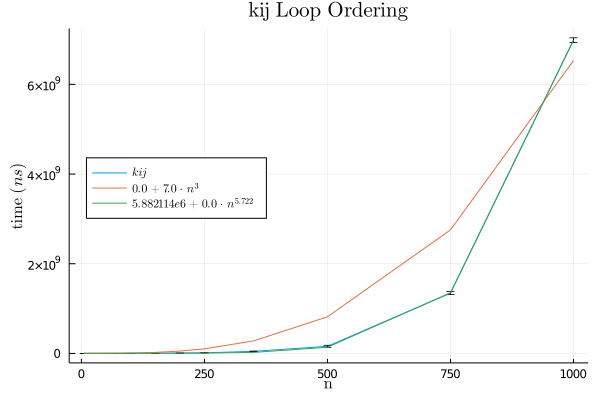

In [96]:
constrained_fit_kij   = curve_fit(constrained_n3_regression , trials, [median(t.times) for t in kij_trials], [0., 1.],
                                  lower=[0., -Inf], upper=[Inf, Inf])
unconstrained_fit_kij = curve_fit(unconstrained_nx_regression, trials, [median(t.times) for t in kij_trials], [0., 1., 3.],
                                  lower=[0., -Inf, 0.], upper=[Inf, Inf, Inf])

p1 = constrained_params_kij   = coef(constrained_fit_kij)
p2 = unconstrained_params_kij = coef(unconstrained_fit_kij)

plot( trials, [median(t.times) for t in kij_trials], yerror=[std(t.times) for t in kij_trials], label=L"kij")
plot!(trials, constrained_n3_regression(trials, constrained_params_kij)  , label=L"%$(round(p1[1])) + %$(round(p1[2])) \cdot n^3")
plot!(trials, unconstrained_nx_regression(trials, unconstrained_params_kij), label=L"%$(round(p2[1])) + %$(round(p2[2])) \cdot n^{ %$(round(p2[3], digits=3))}")
plot!(legend=:left, title=L"\textrm{kij Loop Ordering}", xlabel=L"\textrm{n}", ylabel=L"\textrm{time } (ns)")


Similarly, the multiplicative constant has grown from 2 to 7 and the fit is visually extremely poor. We see the unconstrained model is better, but has an exponent of nearly **6**! That's completely unexpected and caused by awful cache behavior. If we were to look at this plot alone, we would say there is **no way** our algorithm is experimentally in $O(n^3)$, and in a sense that conclusion isn't wrong because the cache misses are outweighing the $O(n^3)$ looping. But we also know that other variations of this algorithm perform exerimentally in $O(n^3)$ on this machine. 

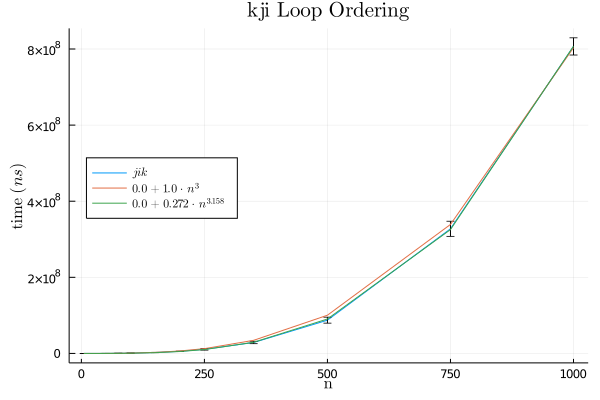

In [99]:
constrained_fit_kji   = curve_fit(constrained_n3_regression , trials, [median(t.times) for t in kji_trials], [0., 1.],
                                  lower=[0., -Inf], upper=[Inf, Inf])
unconstrained_fit_kji = curve_fit(unconstrained_nx_regression, trials, [median(t.times) for t in kji_trials], [0., 1., 3.],
                                  lower=[0., -Inf, 0.], upper=[Inf, Inf, Inf])

p1 = constrained_params_kji   = coef(constrained_fit_kji)
p2 = unconstrained_params_kji = coef(unconstrained_fit_kji)

plot( trials, [median(t.times) for t in kji_trials], yerror=[std(t.times) for t in kji_trials], label=L"jik")
plot!(trials, constrained_n3_regression(trials, constrained_params_kji)  , label=L"%$(round(p1[1])) + %$(round(p1[2])) \cdot n^3")
plot!(trials, unconstrained_nx_regression(trials, unconstrained_params_kji), label=L"%$(round(p2[1], digits=3)) + %$(round(p2[2], digits=3)) \cdot n^{ %$(round(p2[3], digits=3))}")
plot!(legend=:left, title=L"\textrm{kji Loop Ordering}", xlabel=L"\textrm{n}", ylabel=L"\textrm{time } (ns)")


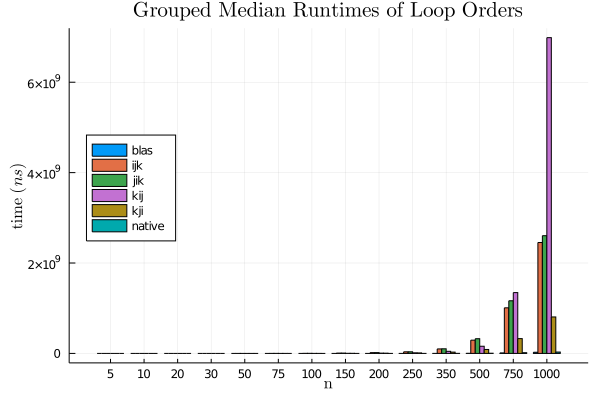

In [153]:
using StatPlots
using CategoricalArrays
ijk = [median(t.times) for t in ijk_trials]
jik = [median(t.times) for t in jik_trials]
kij = [median(t.times) for t in kij_trials]
kji = [median(t.times) for t in kji_trials]
native = [median(t.times) for t in native_trials]
blas = [median(t.times) for t in blas_trials]

ctg = CategoricalArray(repeat(["ijk", "jik", "kij", "kji", "native", "blas"], inner = 14))
nam = CategoricalArray(repeat(["$t" for (i, t) in enumerate(trials)], outer = 6))
levels!(nam, ["$t" for (i, t) in enumerate(trials)])

groupedbar(nam, hcat(ijk, jik, kij, kji, native, blas), group=ctg, bar_position = :dodge, bar_width=0.8)
plot!(legend=:left, title=L"\textrm{Grouped Median Runtimes of Loop Orders}", xlabel=L"\textrm{n}", ylabel=L"\textrm{time } (ns)")

# Conclusion
Here we see everything together. It is clear that $kji$ loop ordering is by far the best, outperforming $kij$ (the worst) at $n$=1000 by *over 8.5x*! It outperforms $ijk$ (the naive) by 3x at $n$=1000 as well. For overall comparisons, we can compare the multaplicative constants by the constrained models and see the $kji$ outperforms $kij$ generally by 7x, and $ijk$ by 2x. We might further constrain the model to have a 0 intercept in order to eliminate it as a variable, allowing for better comparisons of the multiplicative constants. 

It is clear that $kji$ is the best performant loop ordering, and that our errors with each benchmark respectively are reasonable (especially w.r.t the number of samples and lack of time put into benchmarking).

In the end were we all that clever? **Hell no**, Julia's native implementation is 27x faster than our best implementation, $kji$, and Julia's BLAS wrapper is 31x faster. You can barely even see them on the bar graph. The native and BLAS implementations represent *years* of a combination of theory and experimental work to optimize everything in linear algebra. It's clear why large scientific algorithms rely so heavily on well-tuned BLAS libraries.